# Retrieve dataset from zip file

In [16]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = 'ForestNetDataset.zip'
extract_to_directory = 'ForestNetDataset/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_directory, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to: {extract_to_directory}")


KeyboardInterrupt: 

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle
import skimage.draw as sk
from fastai.vision.all import *
from fastai.imports import *

# Read data and create DataFrames

In [3]:
train = pd.read_csv('ForestNetDataset/deep/downloads/ForestNetDataset/train.csv')
val = pd.read_csv('ForestNetDataset/deep/downloads/ForestNetDataset/val.csv')

In [4]:
train.drop(columns = ['label','latitude','longitude'], inplace = True)
val.drop(columns = ['label','latitude','longitude'], inplace = True)
train['is_valid'] = False
val['is_valid'] = True
imgset = pd.concat([train,val],ignore_index = True)
imgset.head()

,merged_label,year,example_path,is_valid
0,Plantation,2014,examples/4.430849118860583_96.1016343478138,False
1,Other,2012,examples/1.3323406178609702_109.37422873130464,False
2,Grassland shrubland,2016,examples/-1.720266384577504_115.00699582064485,False
3,Smallholder agriculture,2011,examples/-2.248346072674411_104.1357857482906,False
4,Plantation,2008,examples/-2.100800102991412_113.0223763234016,False


In [5]:
codes_dict = {"Undefined": 0, "Plantation": 1, "Smallholder agriculture": 2,"Other": 3,"Grassland shrubland": 4}
codes_dict.values()

dict_values([0, 1, 2, 3, 4])

# Semantic segmentation data prep

In [6]:
def getEdges(polygon):
    edge = []
    for i in polygon.exterior.coords:
        x,y = i
        x = np.round(x).astype(int)
        y = np.round(y).astype(int)
        edge.append((x,y))
    return edge

In [7]:
def createPILMask(poly, label, codes):
    mask = np.zeros((332, 332))
    edge = []

    # Check if the geometry is a Polygon
    if poly.geom_type == 'Polygon':
        edge = getEdges(poly)
        pmask = sk.polygon2mask((332, 332), edge)
        mask = np.logical_or(mask, pmask)
    # Check if the geometry is a MultiPolygon
    elif poly.geom_type == 'MultiPolygon':
        for polygon in poly.geoms:  # Access each Polygon using the geoms attribute
            edge = getEdges(polygon)
            pmask = sk.polygon2mask((332, 332), edge)
            mask = np.logical_or(mask, pmask)

    # Convert mask to uint8 and apply label
    mask = np.uint8(mask)
    mask = mask * labelToInt(label, codes)
    mask = np.rot90(mask, 1)

    return PILMask.create(mask)

In [8]:
def labelToInt(label,codes):
    for j,i in enumerate(codes):
        if (i == label):
            return j

In [9]:
def getForestLoss(path):
    with open('ForestNetDataset/deep/downloads/ForestNetDataset/'+ path +'/forest_loss_region.pkl', 'rb') as f:
        return pickle.load(f)

# Find suitable weights for the labels

In [10]:
train_count = train.merged_label.value_counts()
train_count

merged_label
Plantation                 686
Smallholder agriculture    556
Other                      231
Grassland shrubland        143
Name: count, dtype: int64

In [11]:
val_count = val.merged_label.value_counts()
val_count

merged_label
Plantation                 218
Smallholder agriculture    140
Other                       70
Grassland shrubland         45
Name: count, dtype: int64

In [12]:
norm_train = np.linalg.norm(np.array(train_count.values))
norm_val = np.linalg.norm(np.array(val_count.values))

In [13]:
n_1 = ((train_count / norm_train).values)
n_2 = ((val_count / norm_val).values)
weights = (n_1 + n_2) / 2
# Assign a weight of zero to the "Undefined" label.
weights = np.insert(weights[::-1],0,0.0)
print(codes_dict.keys())
weights

dict_keys(['Undefined', 'Plantation', 'Smallholder agriculture', 'Other', 'Grassland shrubland'])


array([0.        , 0.16007583, 0.25363712, 0.558147  , 0.77182238])

# Put the data in a DataBlock

In [18]:
def find_closest_image(image_dir, target_year):
    image_files = glob.glob(os.path.join(image_dir, "*.png"))
    closest_image = None
    closest_diff = float('inf')
    
    for img_file in image_files:
        filename = os.path.basename(img_file)
        if 'composite.png' in filename:
            continue
        img_year = int(filename.split('_')[0])
        diff = abs(img_year - target_year)
        if diff < closest_diff:
            closest_diff = diff
            closest_image = img_file
    
    if closest_image is None:
        closest_image = os.path.join(image_dir, 'composite.png')
    
    return closest_image

In [19]:
def get_image_path(x):
    image_dir = os.path.join("ForestNetDataset", "deep", "downloads", "ForestNetDataset", x[2], "images", "visible")
    target_year = int(x[1])  # Assuming x[1] contains the target year
    return find_closest_image(image_dir, target_year)

In [20]:
db = DataBlock(blocks = (ImageBlock, MaskBlock(codes = codes_dict)),
        splitter = ColSplitter(),
        get_x = get_image_path,
        get_y = lambda x: createPILMask(getForestLoss(x[2]),x[0],codes_dict),
        item_tfms=Resize(160,method = 'crop'),
        batch_tfms=[Normalize.from_stats(*imagenet_stats)])

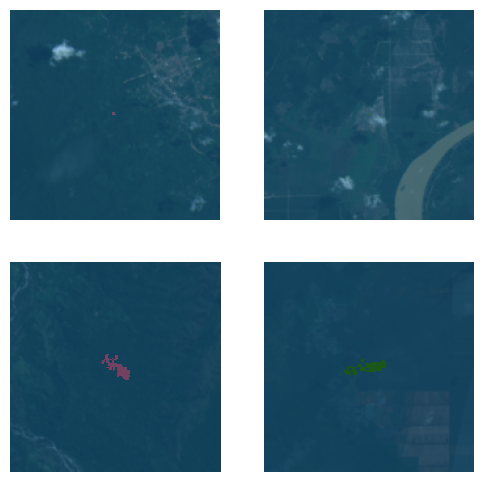

In [21]:
dls = db.dataloaders(imgset, bs = 4, shuffle=True)
dls.show_batch(vmin = 0,vmax = 5)

#Metrics

In [22]:
def accuracy(inp, targ):
    targ = targ.squeeze(1)
#   skip "Undefined"
    mask = targ != 0
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

#Learner and training

In [23]:
learn = unet_learner(dls,
                     resnet34,
                     metrics = accuracy,
                     loss_func = LabelSmoothingCrossEntropyFlat(axis = 1,
                         weight = tensor(weights).cuda()))
learn.loss_func

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

#Validation accuracy

In [ ]:
preds = learn.get_preds()
preds[0].shape

In [ ]:
def label_predict(target,pred,codes,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    label_vals = [pred_labels[i[0]][i[1]].item() for i in maskindices]
    return list(codes)[scipy.stats.mode(label_vals)[0][0]]

In [ ]:
def accuracy(preds,df,codes):
    acc = {}
#   Ideally I dont want any predictions for the undefined label, unfortunately there are a few for most labels
    undefined_count = 0
    for label in df.merged_label.value_counts().index:
        label_indices = df[df.merged_label == label].index
        acc[label] = [label_predict(preds[1][ind],preds[0][ind],codes_dict,False) for ind in label_indices]
    for key in acc.keys():
        vals = acc[key]
#         undefined_count += len([x for x in vals if "Undefined" in x])
        acc[key] = len([x for x in vals if key in x]) / len(vals)
#     print('undefined', undefined_count)
    return acc

In [ ]:
vset = imgset[imgset.is_valid == True]
vset.reset_index(drop = True, inplace = True)
accuracy(preds,vset,codes_dict)

In [ ]:
def predict_mask(target,pred,test):
    maskindices = np.nonzero(target)
    if test:
        maskindices = zip(maskindices[0],maskindices[1])
    pred_labels = pred.argmax(dim = 0)
    p_mask = np.zeros(target.shape)
    for i in maskindices:
        p_mask[i[0]][i[1]] = pred_labels[i[0]][i[1]].item()
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    ax[0].imshow(target)
    ax[1].imshow(p_mask)
    ax[0].set_title("ground truth")
    ax[1].set_title("prediction")
    plt.show()

#Visualize predictions

In [ ]:
predict_mask(preds[1][2],preds[0][2],False)
p = label_predict(preds[1][2],preds[0][2],codes_dict,False)
g = vset.iloc[1][0]
print("predicted label: ", p)
print("correct label: ", g)

In [ ]:
for i, j in enumerate(vset.head(10).values):
    f, ax = plt.subplots(1,2,figsize=(20, 10))
    im = PILImage.create("/content/deep/downloads/ForestNetDataset/"f'{j[1]}'"/images/visible/composite.png")
    ax[0].imshow(im)
    ax[1].imshow(preds[0][i].argmax(dim = 0))
    plt.show()

#Examine model performance on test data

In [ ]:
test = pd.read_csv('/content/deep/downloads/ForestNetDataset/test.csv')
test.drop(columns = ['label','latitude','longitude','year'], inplace = True)

In [ ]:
def t_acc(df,codes):
#     undefined_count = 0
    acc = []
    label = df.iloc[0][0]
    for x in df.values:
        im = PILImage.create("/content/deep/downloads/ForestNetDataset/"f'{x[1]}'"/images/visible/composite.png")
        AOI = createPILMask(getForestLoss(x[1]),x[0],codes)
        p = learn.predict(im)
        acc.append(label_predict(AOI.crop_pad(p[2].shape[1]),p[2],codes,True))
#     print(len([x for x in acc if "Undefined" in x]))
    return (len([x for x in acc if label in x]) / len(acc))

In [ ]:
t_plant = test[test.merged_label == 'Plantation']
t_other = test[test.merged_label == 'Other']
t_grass = test[test.merged_label == 'Grassland shrubland']
t_small = test[test.merged_label == 'Smallholder agriculture']

plantation = t_acc(t_plant,codes_dict)
other = t_acc(t_other,codes_dict)
grass = t_acc(t_grass,codes_dict)
small = t_acc(t_small,codes_dict)

In [ ]:
print('plantation accuracy: ', np.around(plantation,4))
print('other accuracy: ', np.around(other,4))
print('grassland shrubland accuracy: ', np.around(grass,4))
print('smallholder agriculture accuracy: ', np.around(small,4))